[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Azimi/box.ipynb)  
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/deJong_Azimi/box.ipynb)    
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Azimi/box.ipynb)

In [1]:
from typing import Optional

import numpy as np
from scipy.special import gamma
from matplotlib import pyplot
import xarray as xr

from open_atmos_jupyter_utils import show_plot

from PySDM_examples.deJong_Azimi import run_box

from PySDM import Formulae
from PySDM.physics import si, in_unit
from PySDM.dynamics.collisions.collision_kernels import SimpleGeometric, Golovin
from PySDM.dynamics.collisions.coalescence_efficiencies import ConstEc
from PySDM.initialisation.spectra import Gamma

In [2]:
class Settings0D:  # pylint: disable=too-many-instance-attributes,too-few-public-methods,missing-class-docstring
    def __init__(
        self,
        kernel: object,
        steps: list,
        radius_bins_edges: Optional[np.ndarray] = None,
    ):
        self.kernel = kernel
        self.n_sd = 2**12
        self.n_part = 100 / si.cm**3
        self.dv = 1 * si.m**3
        self.rho = 1000 * si.kg / si.m**3
        self.rhod = 1 * si.kg / si.m**3
        self.dt = 1 * si.s
        self.adaptive = True
        self.steps = steps
        self.coal_eff = ConstEc(Ec=1.0)
        self.spectrum = Gamma(
            norm_factor=self.n_part * self.dv, k=1.0, theta=1e5 * si.um**3
        )
        self.radius_bins_edges = radius_bins_edges if radius_bins_edges is not None else np.logspace(
            np.log10(8.0 * si.um), np.log10(5000 * si.um), num=64, endpoint=True
        )
        self.formulae = Formulae(terminal_velocity="PowerSeries")

In [3]:
def dvdlnr_gamma(m, N, theta, k):
    return N * m**(k-1) * np.exp(-m / theta) / theta**k / gamma(k)

## Golovin Kernel

In [4]:
settings_a = Settings0D(
    kernel = Golovin(b=5e3 * si.s),
    steps = [0, 60, 120]
)
res_a = run_box(settings_a)

In [5]:
ds1 = xr.open_dataset("box_single_gamma_golovin.nc")
ds2 = xr.open_dataset("box_double_gamma_golovin.nc")
ds3 = xr.open_dataset("box_three_gamma_golovin.nc")

/Users/emilydejong/opt/anaconda3/envs/edjPySDM/lib/python3.9/site-packages/xarray/backends/plugins.py:65: RuntimeWarning: Engine 'rasterio' loading failed:
dlopen(/Users/emilydejong/opt/anaconda3/envs/edjPySDM/lib/python3.9/site-packages/rasterio/_base.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/libpoppler.91.dylib
  Referenced from: <0B63E196-8B06-333E-89EA-5BB2851BB4E2> /Users/emilydejong/opt/anaconda3/envs/edjPySDM/lib/libgdal.26.dylib
  Reason: tried: '/Users/emilydejong/opt/anaconda3/envs/edjPySDM/lib/libpoppler.91.dylib' (no such file), '/Users/emilydejong/opt/anaconda3/envs/edjPySDM/lib/libpoppler.91.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/emilydejong/opt/anaconda3/envs/edjPySDM/lib/libpoppler.91.dylib' (no such file), '/Users/emilydejong/opt/anaconda3/envs/edjPySDM/lib/libpoppler.91.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/emilydejong/opt/anaconda3/envs/edjPySDM/lib/libpoppler.91.dylib' (no such file), '/Users/e

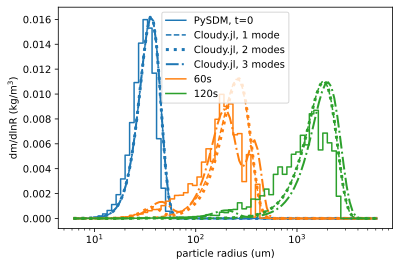

HTML(value="<a href='./box1.pdf' target='_blank'>./box1.pdf</a><br>")

In [6]:
fig, ax = pyplot.subplots(ncols=1, sharey=True, figsize=(6,4), dpi=200)

m_plt_ug = np.logspace(-3.0, 6.0, 100)
m_plt_kg = m_plt_ug * 1e-9
r1_plt = settings_a.formulae.trivia.radius(volume=m_plt_ug * si.ug / settings_a.rho)

for (j, step) in enumerate(settings_a.steps):
    line = ax.step(
        in_unit(res_a.radius_bins_left_edges, si.um),
        res_a.dv_dlnr[j] * settings_a.rho,
        label='PySDM, t=0' if j==0 else (str(step) + 's')
    )
    a1_dmdlnr = dvdlnr_gamma(
        m_plt_kg,
        ds1["params"].where(ds1["time"] == step, drop=True)[0][0][0].item(),
        ds1["params"].where(ds1["time"] == step, drop=True)[1][0][0].item(),
        ds1["params"].where(ds1["time"] == step, drop=True)[2][0][0].item(),
    ) * 3 * m_plt_kg**2 * si.kg / si.m**3
    ax.plot(
        in_unit(r1_plt, si.um),
        in_unit(a1_dmdlnr, si.kg / si.m**3),
        '--',
        label='Cloudy.jl, 1 mode' if j==0 else '_',
        color=line[-1].get_color()
    )

    b1_dmdlnr = np.zeros_like(a1_dmdlnr)
    for k in ds2["dist"]:
        b1_dmdlnr += dvdlnr_gamma(
            m_plt_kg,
            ds2["params"].where(ds2["time"] == step, drop=True)[0][k][0].item(),
            ds2["params"].where(ds2["time"] == step, drop=True)[1][k][0].item(),
            ds2["params"].where(ds2["time"] == step, drop=True)[2][k][0].item()
        ) * 3 * m_plt_kg**2 * si.kg / si.m**3
    ax.plot(
        in_unit(r1_plt, si.um),
        b1_dmdlnr,
        ':',
        label='Cloudy.jl, 2 modes' if j==0 else '_',
        color=line[-1].get_color(),
        lw=3
    )

    c1_dmdlnr = np.zeros_like(a1_dmdlnr)
    for k in ds3["dist"]:
        c1_dmdlnr += dvdlnr_gamma(
            m_plt_kg,
            ds3["params"].where(ds3["time"] == step, drop=True)[0][k][0].item(),
            ds3["params"].where(ds3["time"] == step, drop=True)[1][k][0].item(),
            ds3["params"].where(ds3["time"] == step, drop=True)[2][k][0].item()
        ) * 3 * m_plt_kg**2 * si.kg / si.m**3
    ax.plot(
        in_unit(r1_plt, si.um),
        c1_dmdlnr,
        ls='-.',
        label='Cloudy.jl, 3 modes' if j==0 else '_',
        color=line[-1].get_color(),
        lw=2
    )

ax.set_xscale("log")
ax.set_xlabel("particle radius (um)")
ax.set_ylabel("dm/dlnR (kg/m$^3$)")
ax.legend()
show_plot('box1.pdf')

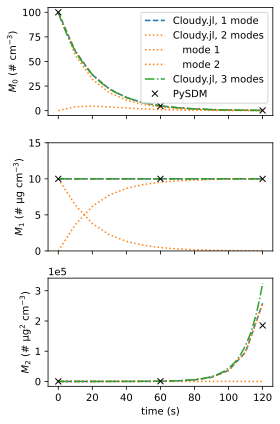

HTML(value="<a href='./box1_moments.pdf' target='_blank'>./box1_moments.pdf</a><br>")

In [7]:
fig, ax = pyplot.subplots(nrows=3, sharex=True, figsize=(4,6), dpi=200, tight_layout=True)
for i in range(3):
    line = ax[i].plot(
        ds1["time"],
        in_unit(ds1["total_moments"].sel(order=i), si.ug**i / si.cm**3),
        '--',
        label='Cloudy.jl, 1 mode'
    )
    line = ax[i].plot(
        ds2["time"],
        in_unit(ds2["total_moments"].sel(order=i), si.ug**i / si.cm**3),
        ':',
        label='Cloudy.jl, 2 modes'
    )
    for k in ds2["dist"]:
        ax[i].plot(
            ds2["time"],
            in_unit(ds2["moments"].sel(order=i, dist=k), si.ug**i / si.cm**3),
            ':',
            linewidth=1.5, label='   mode '+str(k.item() + 1), color=line[-1].get_color()
        )
    line = ax[i].plot(
        ds3["time"],
        in_unit(ds3["total_moments"].sel(order=i), si.ug**i / si.cm**3),
        '-.',
        label='Cloudy.jl, 3 modes'
    )
    ax[i].plot(
        np.asarray(settings_a.steps) * settings_a.dt,
        in_unit(
            res_a.moments[:, i] * settings_a.dv * settings_a.rho**i,
            si.ug**i / si.cm**3
        ),
        marker='x', linestyle='None', label='PySDM', color='k'
    )
ax[0].legend()
ax[0].set_ylabel('$M_0$ (# cm$^{-3}$)')
ax[1].set_ylabel('$M_1$ (# µg cm$^{-3}$)')
ax[1].set_ylim([0.0, 15.0])
ax[2].set_ylabel('$M_2$ (# µg$^2$ cm$^{-3}$)')
ax[2].set_xlabel('time (s)')
ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0,2))

show_plot('box1_moments.pdf')

## Geometric

In [25]:
ds1 = xr.open_dataset("box_single_gamma_hydro.nc")
ds2 = xr.open_dataset("box_double_gamma_hydro.nc")

In [14]:
settings_b = Settings0D(
    kernel = SimpleGeometric(C=1e6 * np.pi),
    steps = [0, 120, 240],
    radius_bins_edges = np.logspace(
        np.log10(8.0 * si.um), np.log10(10000 * si.um), num=64, endpoint=True
    ),
)
settings_b.dt = 1.0
settings_b.steps = [0, int(120/settings_b.dt), int(240/settings_b.dt)]
res_b = run_box(settings_b)

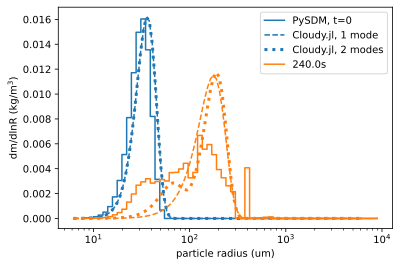

HTML(value="<a href='./box2.pdf' target='_blank'>./box2.pdf</a><br>")

In [21]:
fig, ax = pyplot.subplots(ncols=1, sharey=True, figsize=(6,4), dpi=200)

m_plt_ug = np.logspace(-3.0, 6.0, 100)
m_plt_kg = m_plt_ug * 1e-9

r2_plt = settings_b.formulae.trivia.radius(volume=m_plt_ug * si.ug / settings_b.rho)

for (j, step) in enumerate(settings_b.steps):
    if j == 1:
        continue
    line = ax.step(
        in_unit(res_b.radius_bins_left_edges, si.um),
        res_b.dv_dlnr[j] * settings_b.rho,
        label='PySDM, t=0' if j==0 else (str(step * settings_b.dt) + 's')
    )
    step = step * settings_b.dt
    a2_dmdlnr = dvdlnr_gamma(
        m_plt_kg,
        ds1["params"].where(ds1["time"] == step, drop=True)[0][0][0].item(),
        ds1["params"].where(ds1["time"] == step, drop=True)[1][0][0].item(),
        ds1["params"].where(ds1["time"] == step, drop=True)[2][0][0].item(),
    ) * 3 * m_plt_kg**2 * si.kg / si.m**3
    ax.plot(
        in_unit(r2_plt, si.um),
        in_unit(a2_dmdlnr, si.kg / si.m**3),
        '--',
        label='Cloudy.jl, 1 mode' if j==0 else '_',
        color=line[-1].get_color()
    )

    b2_dmdlnr = np.zeros_like(a2_dmdlnr)
    for k in ds2["dist"]:
        b2_dmdlnr += dvdlnr_gamma(
            m_plt_kg,
            ds2["params"].where(ds2["time"] == step, drop=True)[0][k][0].item(),
            ds2["params"].where(ds2["time"] == step, drop=True)[1][k][0].item(),
            ds2["params"].where(ds2["time"] == step, drop=True)[2][k][0].item()
        ) * 3 * m_plt_kg**2 * si.kg / si.m**3
    ax.plot(
        in_unit(r2_plt, si.um),
        b2_dmdlnr,
        ':',
        label='Cloudy.jl, 2 modes' if j==0 else '_',
        color=line[-1].get_color(),
        lw=3
    )

ax.set_xscale("log")
ax.set_xlabel("particle radius (um)")
ax.set_ylabel("dm/dlnR (kg/m$^3$)")
ax.legend()
show_plot('box2.pdf')

In [16]:
settings_c = Settings0D(
    kernel = settings_b.kernel,
    steps = np.linspace(0, 240, 21, dtype=int),
    radius_bins_edges = settings_b.radius_bins_edges,
)
res_c = run_box(settings_c)

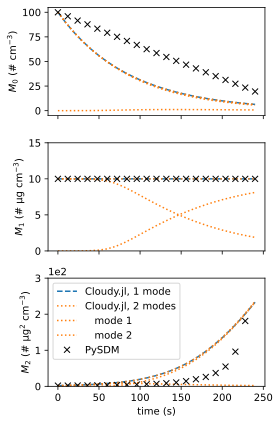

HTML(value="<a href='./box2_moments.pdf' target='_blank'>./box2_moments.pdf</a><br>")

In [26]:
fig, ax = pyplot.subplots(nrows=3, sharex=True, figsize=(4,6), dpi=200, tight_layout=True)
for i in range(3):
    line = ax[i].plot(
        ds1["time"],
        in_unit(ds1["total_moments"].sel(order=i), si.ug**i / si.cm**3),
        '--',
        label='Cloudy.jl, 1 mode'
    )
    line = ax[i].plot(
        ds2["time"],
        in_unit(ds2["total_moments"].sel(order=i), si.ug**i / si.cm**3),
        ':',
        label='Cloudy.jl, 2 modes'
    )
    for k in ds2["dist"]:
        ax[i].plot(
            ds2["time"],
            in_unit(ds2["moments"].sel(order=i, dist=k), si.ug**i / si.cm**3),
            ':',
            linewidth=1.5, label='   mode '+str(k.item() + 1), color=line[-1].get_color()
        )
    ax[i].plot(
        np.asarray(settings_c.steps) * settings_c.dt,
        in_unit(
            res_c.moments[:, i] * settings_c.dv * settings_c.rho**i,
            si.ug**i / si.cm**3
        ),
        marker='x',
        linestyle='None',
        label='PySDM',
        color='k'
    )

ax[2].legend()
ax[0].set_ylabel('$M_0$ (# cm$^{-3}$)')
ax[1].set_ylabel('$M_1$ (# µg cm$^{-3}$)')
ax[1].set_ylim([0.0, 15.0])
ax[2].set_ylim([0.0, 3e2])
ax[2].set_ylabel('$M_2$ (# µg$^2$ cm$^{-3}$)')
ax[2].set_xlabel('time (s)')
ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0,2))

show_plot('box2_moments.pdf')